# Is it possible to determine white wine quality based on its attributes?

## Introduction:

Wine is an alcoholic drink made from fermenting grapes or other fruits. It has many attributes that differ in composition, which gives each wine its own unique characteristics. Many attributes of wine are typically measured as a part of the wine manufacturing process to ensure that the wine is meeting the manufacturer's specifications, is absent of harmful impurities, and is safe to consume. These attributes include:

- fixed acidity (g(tartaric acid)/dm^3)
- volatile acidity (g(acetic acid)/dm^3)
- citric acid (g/dm^3)
- residual sugar (g/dm^3)
- chlorides (g(sodium chloride)/dm^3)
- free sulfur dioxide (mg/dm^3)
- total sulfur dioxide (mg/dm^3)
- density (g/cm^3)
- pH
- sulphates (g(potassium sulphate)/dm^3)
- alcohol (vol.%)


Quality, which is typically determined by professional wine tasters, could be affected by these attributes of wine. The goal of our project is to answer the following question: is it possible to determine white wine quality based on its attributes?

To answer this question, we will be using the Wine Quality dataset from the UC Irvine Machine Learning Repository which can be accessed [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). There are two datasets to choose from: red wine and white wine. We chose the white wine dataset because it has more observations than the red wine dataset. The dataset includes the attributes listed above and a quality rating from 0 to 10 for each wine. 

## Methods:

We will conduct our data analysis by using the $k$-nearest neighbours classification model in conjunction with 5-fold cross validation for selecting our $k$ value. The predictors we will use are volatile acidity and alcohol, and the target variable will be quality for our model. We decided to use these variables after researching which components of white wine could affect its quality, and noticed that volatile acidity and alcohol were reoccurring variables seen in the [sources](#Sources:) at the bottom of the notebook. We will use a variety of methods to visualize the results of our project, including scatter plots, line plots, histograms, and tables. 

## Expected outcomes and significance:

We expect to find that white wine quality can be determined using our chosen predictors. These findings could help wine manufacturers improve their production processes for white wine, as knowing which attributes affect its perceived quality can help fine-tune specific components of the wine-making process. This could lead to future questions such as whether or not other components of wine that were not in the data set could affect white wine quality (grape type, grape size), if external factors can affect white wine quality (environment, harvesting, fermentation), and if a perfect white wine can be made by tuning the correct attributes.

## Data analysis:

### Loading, Cleaning, and Wrangling

In [17]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 11)

After loading the necessary libraries, we can start working with the dataset. We can read the dataset from the internet using ```read_delim``` and clean it by converting the quality column to a factor and removing spaces from the column names. All of the columns in the dataset are doubles except for quality, which was converted from a double to a factor.

In [2]:
wine_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", 
                        delim = ";", show_col_types = FALSE) |>
    mutate(quality = as_factor(quality))

colnames(wine_data) <- make.names(colnames(wine_data))

format("Figure 1: White wine data before split")
wine_data

[1] "Figure 1: White wine data before split"

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.50,11.2,6
6.6,0.32,0.36,8.0,0.047,57,168,0.99490,3.15,0.46,9.6,5


There are no missing or N/A values in our dataset.

In [3]:
cat("Number of missing values:", sum(is.na(wine_data)))

Number of missing values: 0

The seed is set so that ```initial_split``` always produces the same result, and the data is split such that 75% of the data is for training, while 25% is for testing.

In [4]:
set.seed(1234) # setting seed for reproducibility

wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split) 

### Tables

Figure 2 shows the number of observations for each class in the training dataset using ```group_by``` and ```summarize```.

In [5]:
observation_counts <- wine_train |>
    group_by(quality) |>
    summarize(count = n())

format("Figure 2: Number of observations for each class")
observation_counts

[1] "Figure 2: Number of observations for each class"

quality,count
<fct>,<int>
3,14
4,121
5,1091
6,1650
7,665
8,129
9,3


Figure 3 shows the mean, median, minimum, and maximum values for each column of the training dataset.

In [6]:
pred_stats_table <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    group_by(key) |>
    summarize(mean = mean(value), median = median(value), min = min(value), max = max(value))

format("Figure 3: Summary of training dataset")
pred_stats_table

[1] "Figure 3: Summary of training dataset"

key,mean,median,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alcohol,10.50555132,10.4000,8.00000,14.05000
chlorides,0.04569289,0.0430,0.00900,0.34600
citric.acid,0.33459025,0.3200,0.00000,1.66000
density,0.99407305,0.9938,0.98711,1.03898
fixed.acidity,6.85144296,6.8000,3.80000,14.20000
free.sulfur.dioxide,35.21753335,34.0000,2.00000,289.00000
pH,3.18849442,3.1700,2.74000,3.82000
residual.sugar,6.46768309,5.4000,0.60000,65.80000
sulphates,0.48907433,0.4700,0.22000,1.08000


### Visualizations

In Figure 4, the distribution of the number of observations for each class is skewed slightly to the left, and a quality score of 6 was the most common in the full dataset. We observed that there are no observations of quality level 0, 1, 2, or 10 in the dataset.

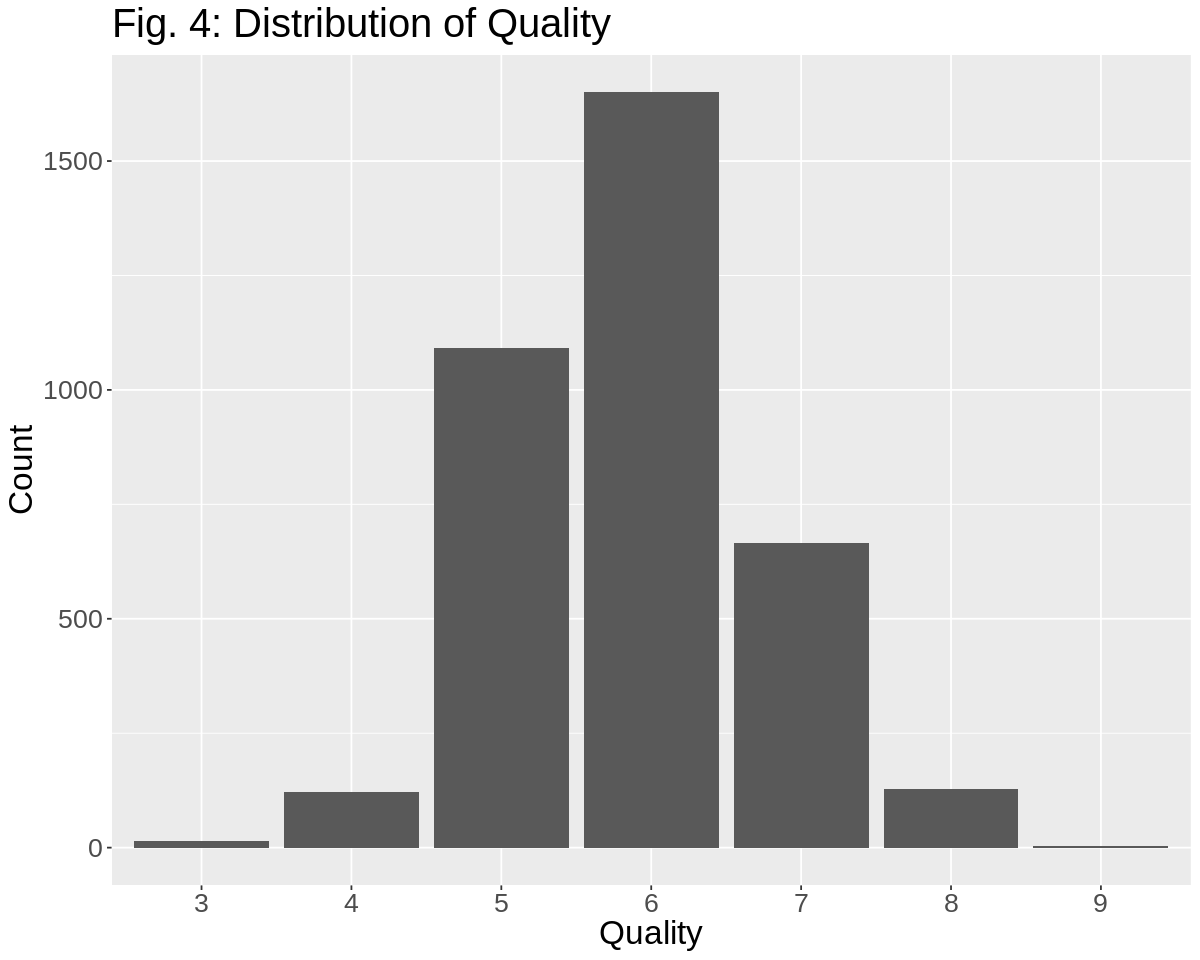

In [7]:
options(repr.plot.width = 10, repr.plot.height = 8)

observation_plot <- wine_train |>
    ggplot(aes(x = quality)) +
    geom_bar() +
    theme(text = element_text(size = 20)) + 
    ggtitle("Fig. 4: Distribution of Quality") +
    labs(x = "Quality", y = "Count")

observation_plot

After plotting the distributions of each predictor variable in Figure 5, we see that some variables have narrow distributions (chlorides, citric acid), some variables have broad distributions (pH, sulphates), and one variable is more spread out (alcohol).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



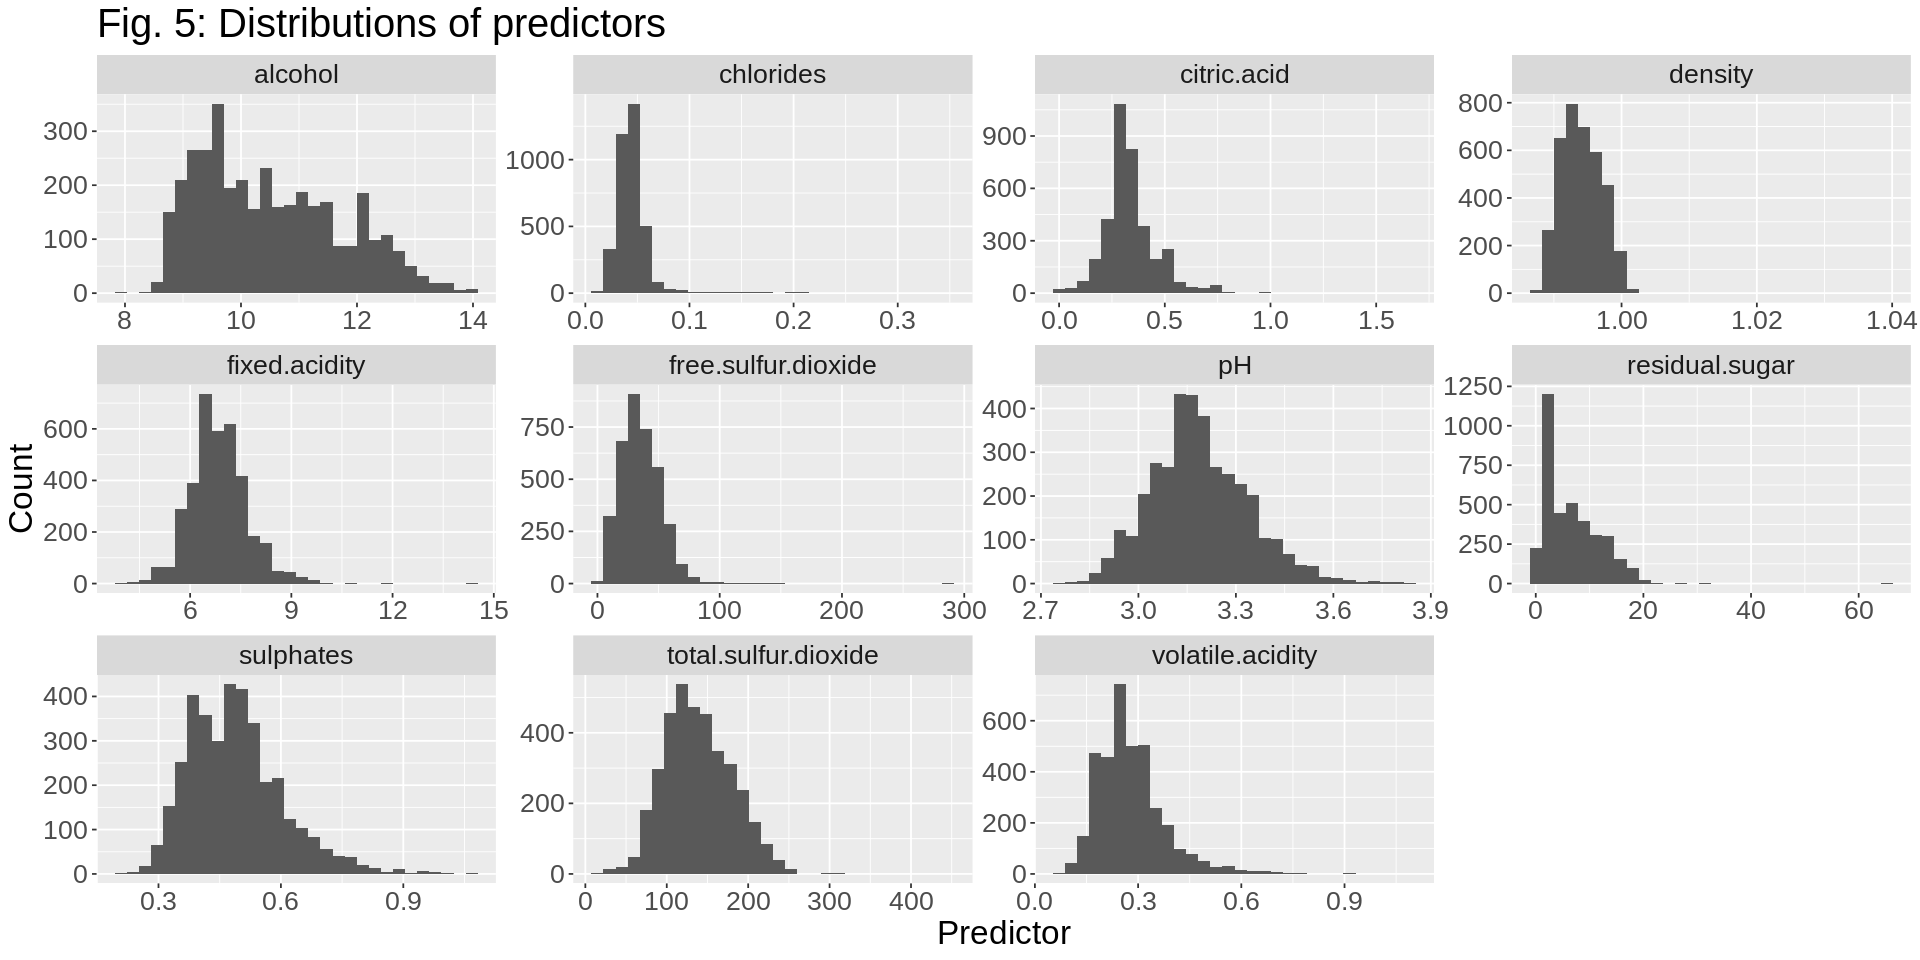

In [8]:
options(repr.plot.width = 16, repr.plot.height = 8)

pred_dist_plot <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    mutate(value = as.double(value)) |> 
    ggplot(aes(x = value)) + 
    geom_histogram() +
    facet_wrap(~ key, scales = "free") +
    theme(text = element_text(size = 20)) + 
    labs(x = "Predictor", y = "Count", title = "Fig. 5: Distributions of predictors")

pred_dist_plot

In Figure 6, there appears to be a weak but slightly positive relationship between alcohol content and quality.

`geom_smooth()` using formula 'y ~ x'



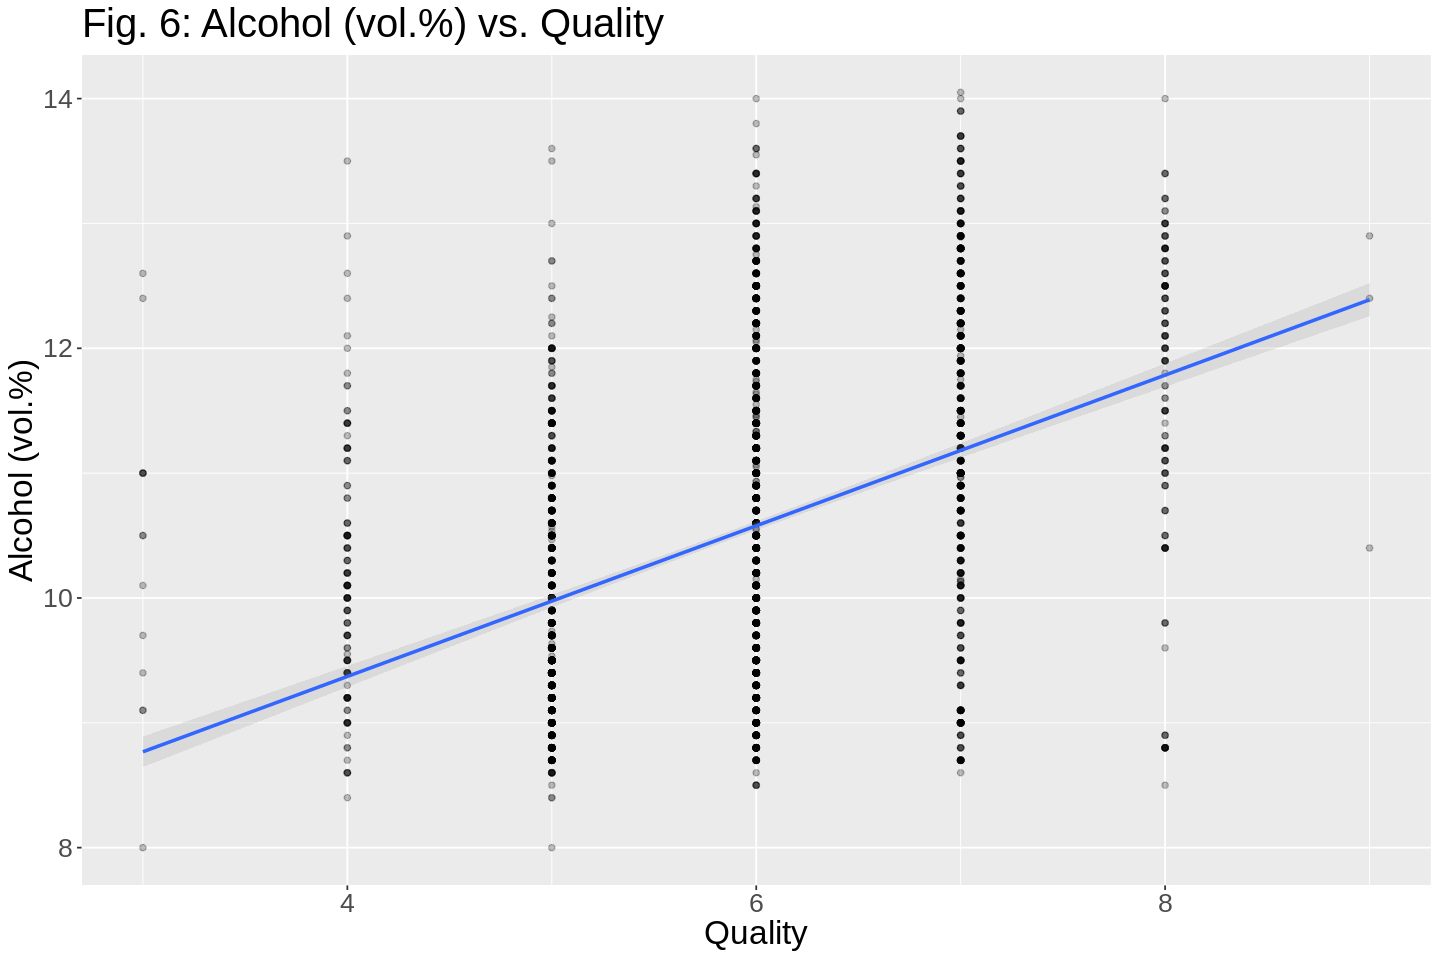

In [9]:
options(repr.plot.width = 12, repr.plot.height = 8)

alcohol_vs_quality_plot <- wine_train |>
    mutate(quality = as.numeric(levels(quality))[quality]) |> # convert quality back to double
    ggplot(aes(x = quality, y = alcohol)) + 
    geom_point(alpha = 0.25) +
    geom_smooth(method = "lm", alpha = 0.2) +
    theme(text = element_text(size = 20)) + 
    labs(x = "Quality", y = "Alcohol (vol.%)", title = "Fig. 6: Alcohol (vol.%) vs. Quality")

alcohol_vs_quality_plot

Using the ```ggpairs``` function from the GGally library, we can make a correlation matrix to observe the correlation coefficients between the variables.

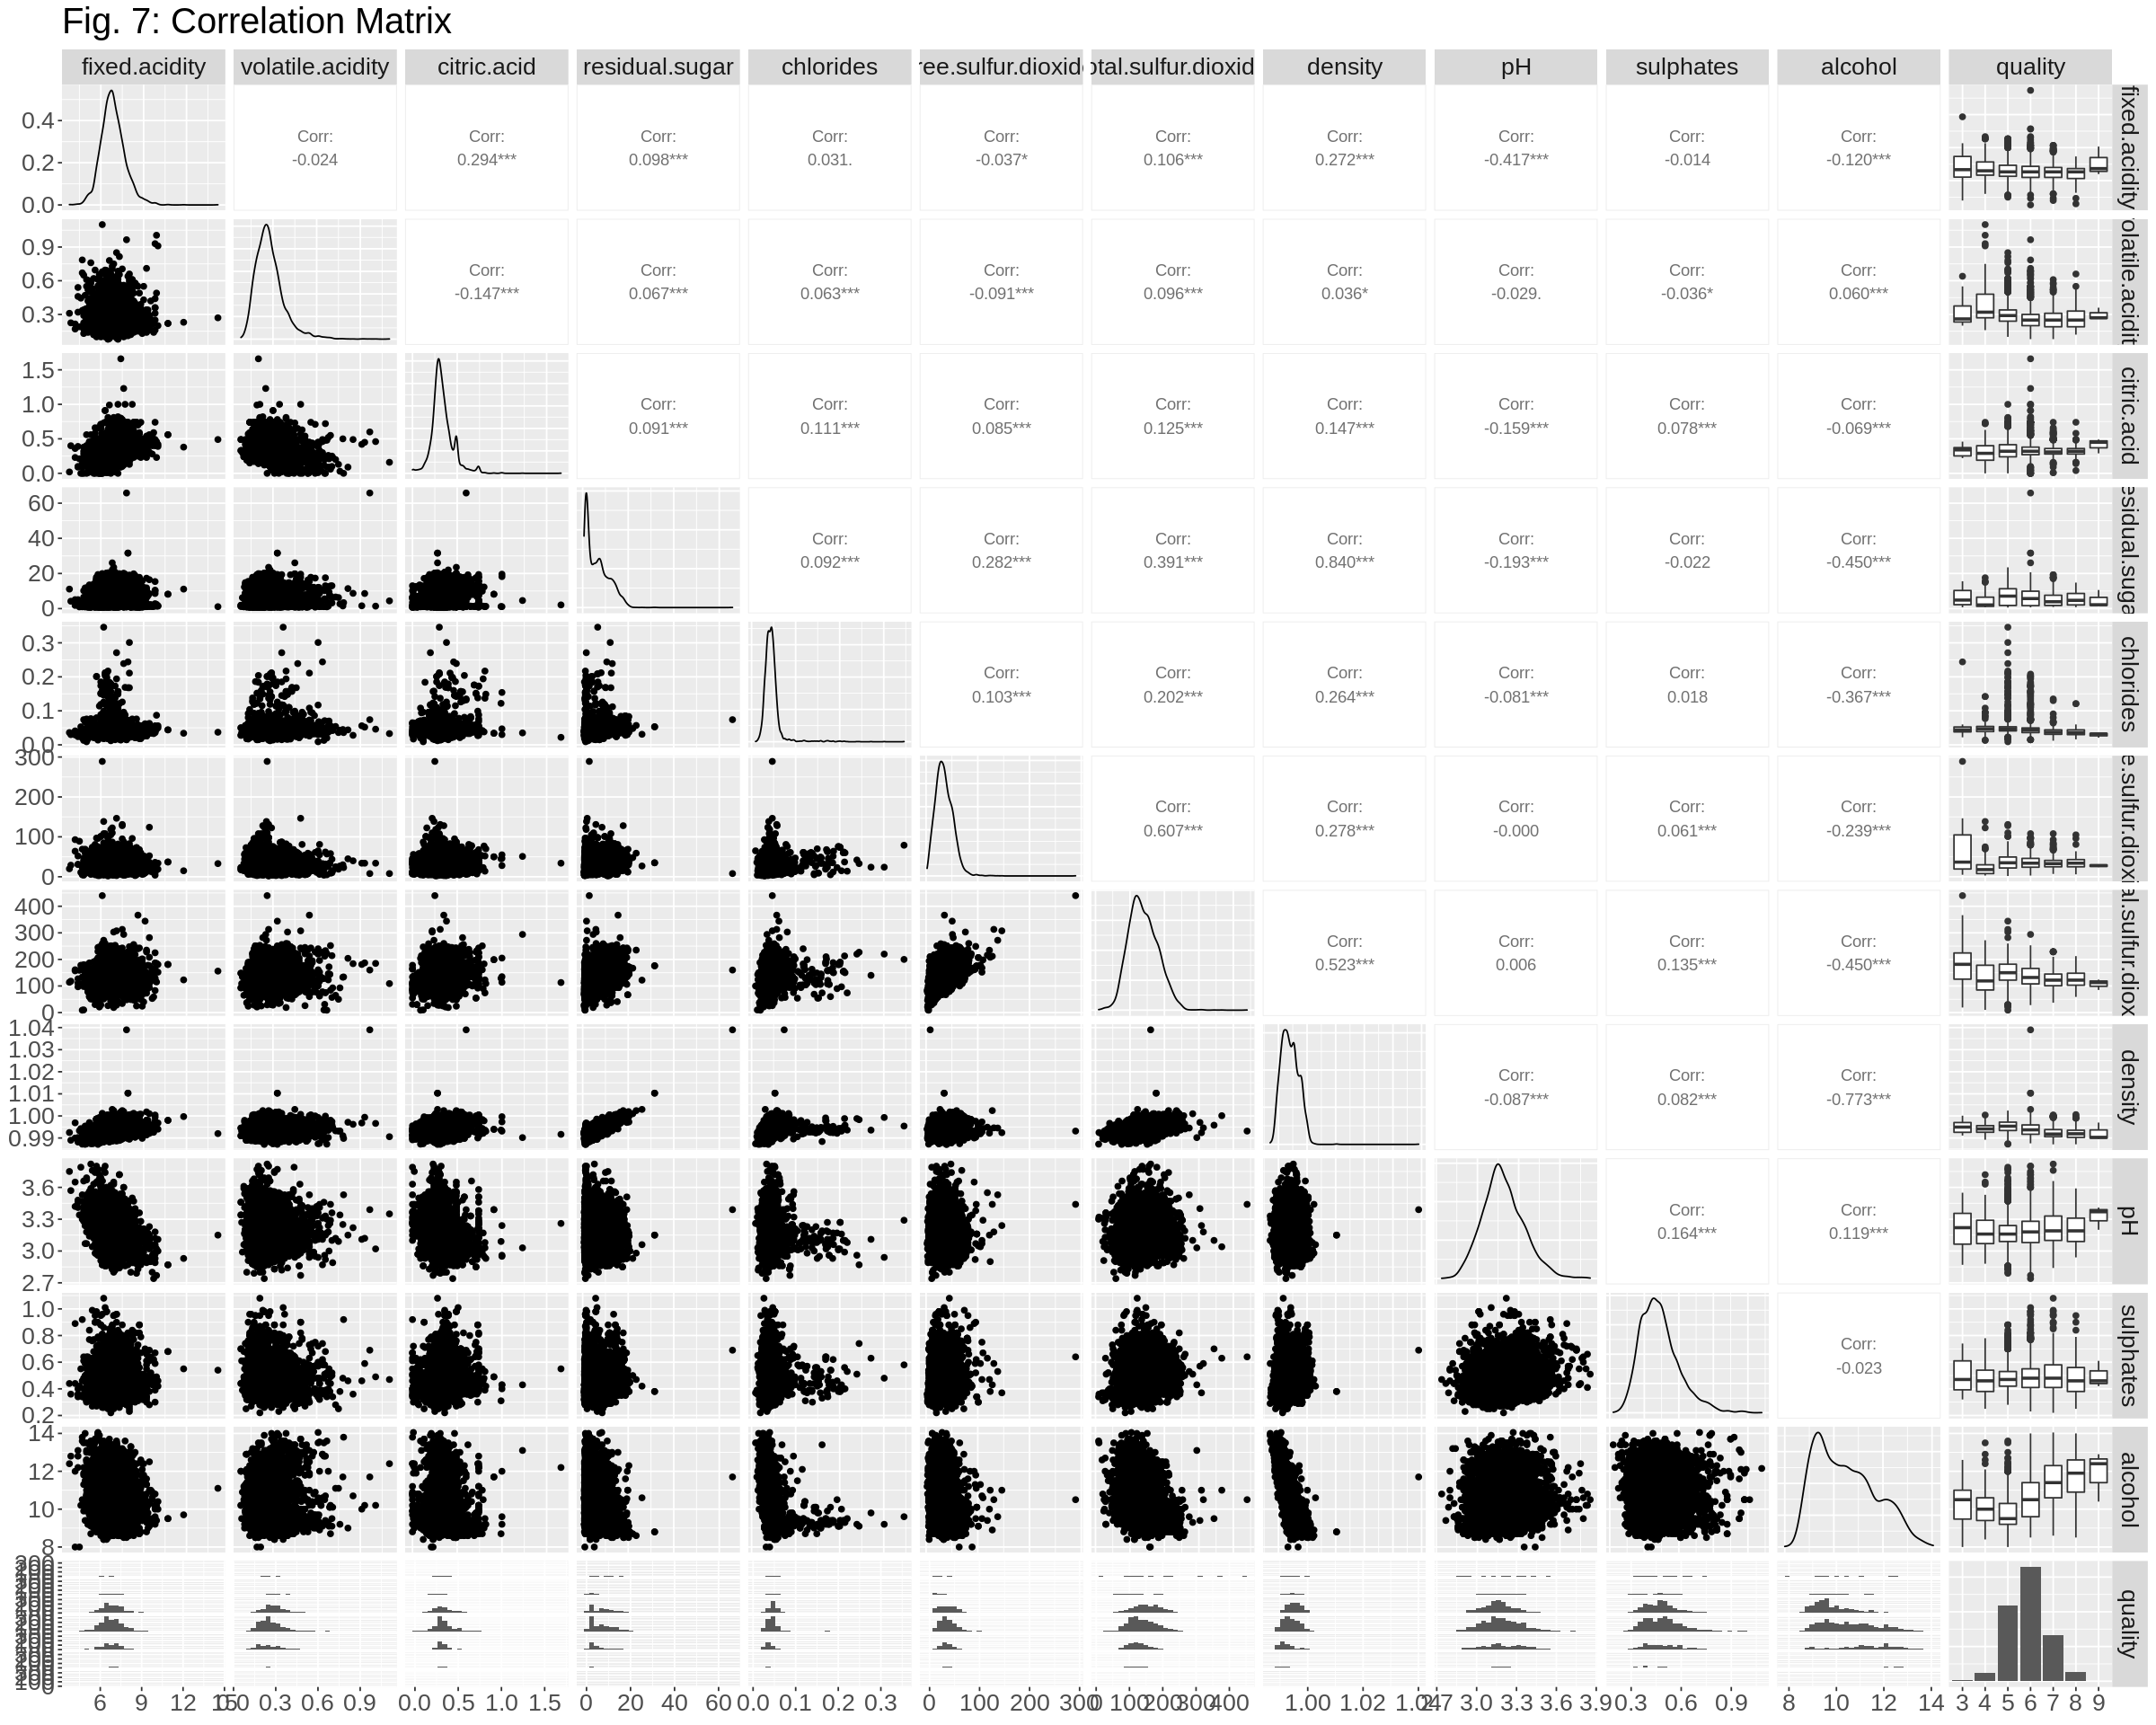

In [10]:
options(repr.plot.width = 20, repr.plot.height = 16)

correlation_plot <- wine_train |>
    ggpairs(title = "Fig. 7: Correlation Matrix") +
    theme(text = element_text(size = 20))

suppressMessages(print(correlation_plot)) # remove messages about binwidth

### Classification

First, we will pre-process the training data in a recipe by using ```step_scale``` and ```step_center``` to standardize the data.

In [11]:
wine_recipe <- recipe(quality ~ volatile.acidity + alcohol, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

The next cell does the following:
- creates values of $k$ for cross-validation
- creates a model for tuning the neighbors
- splits the training data into 5 folds
- runs the 5-fold cross validation to determine a value for $k$
- creates a line plot depicting estimated accuracy vs. neighbors ($k$) 

Figure 8 shows the results of the 5-fold cross validation, and Figure 9 visualizes the results in a line plot. We observed that $k$ = 51 has the highest accuracy from Figure 8 and 9, but not by a significant margin. This cell will take a long time to run. (~20-25 min)

! Fold3: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.



[1] "Figure 8: K-tuning results for k = 1 to 201, by steps of 10"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
51,accuracy,multiclass,0.5360815,5,0.004704955,Preprocessor1_Model06
91,accuracy,multiclass,0.5314534,5,0.005378276,Preprocessor1_Model10
81,accuracy,multiclass,0.5314508,5,0.005044605,Preprocessor1_Model09
41,accuracy,multiclass,0.5309040,5,0.004750810,Preprocessor1_Model05
61,accuracy,multiclass,0.5298159,5,0.006043389,Preprocessor1_Model07
101,accuracy,multiclass,0.5287253,5,0.004355704,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
121,accuracy,multiclass,0.5213758,5,0.003485807,Preprocessor1_Model13
201,accuracy,multiclass,0.5213732,5,0.004795318,Preprocessor1_Model21


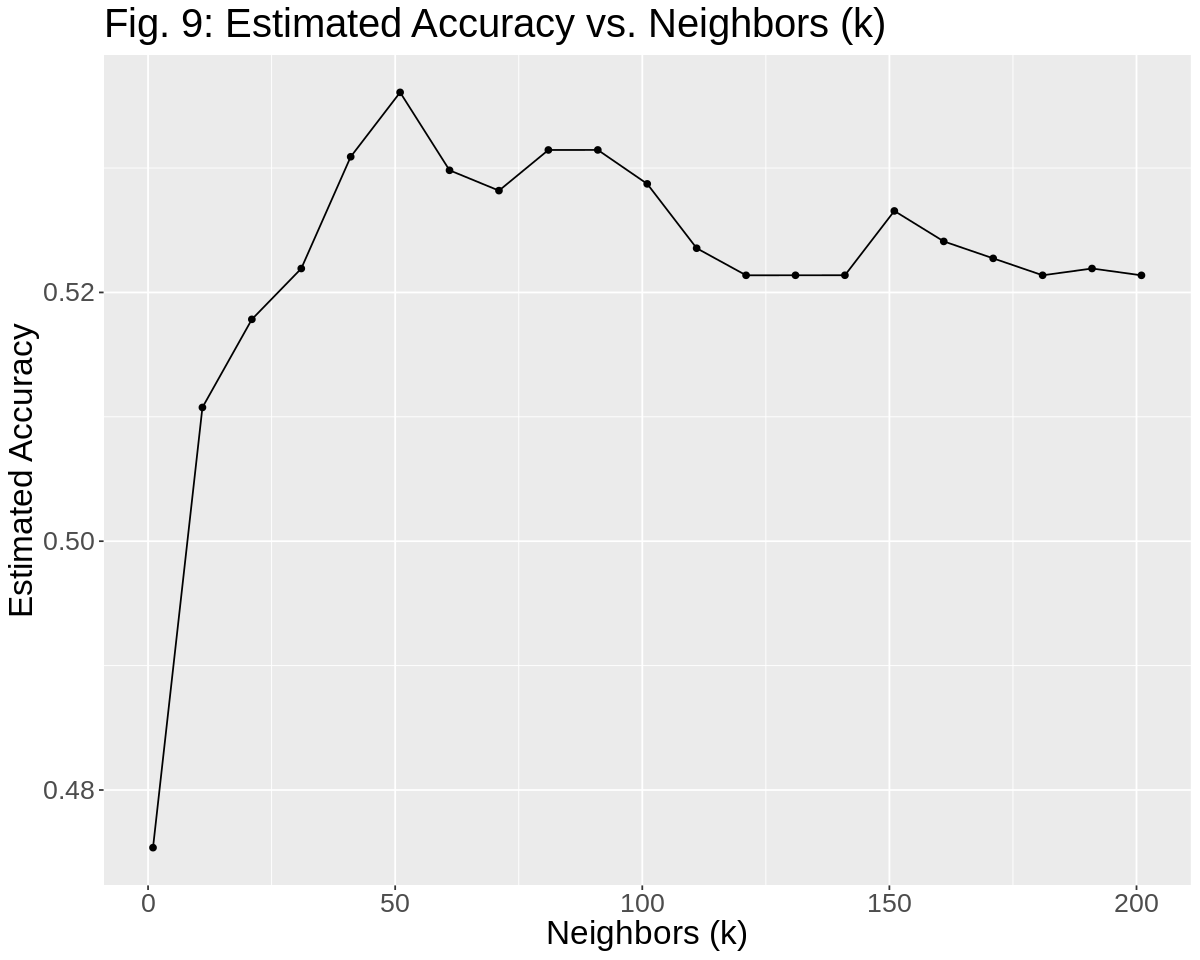

In [12]:
set.seed(1234) # setting seed for reproducibility

gridvals <- tibble(neighbors = seq(from = 1, to = 201, by = 10)) # long run time

# gridvals <- tibble(neighbors = seq(from = 41, to = 61, by = 10)) # shorter run time

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

wine_tune_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

format("Figure 8: K-tuning results for k = 1 to 201, by steps of 10")
wine_tune_results

options(repr.plot.width = 10, repr.plot.height = 8)

accuracy_plot <- wine_tune_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors (k)", y = "Estimated Accuracy", title = "Fig. 9: Estimated Accuracy vs. Neighbors (k)") +
    theme(text = element_text(size = 20))

accuracy_plot

After determining a value for $k$, we can create the model and use ```wine_test```, our testing data, to make predictions with the model.

In [13]:
knn_fit <- nearest_neighbor(weight_func = "rectangular", neighbors = 51) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_fit) |>
    fit(data = wine_train)

wine_predictions <- predict(wine_fit, wine_test) |>
    bind_cols(wine_test)

format("Figure 10: Model predictions on testing data")
wine_predictions

[1] "Figure 10: Model predictions on testing data"

.pred_class,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,6.3,0.30,0.34,1.60,0.049,14,132,0.9940,3.30,0.49,9.5,6
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5
6,7.9,0.18,0.37,1.20,0.040,16,75,0.9920,3.18,0.63,10.8,5
6,7.4,0.34,0.42,1.10,0.033,17,171,0.9917,3.12,0.53,11.3,6
6,6.2,0.66,0.48,1.20,0.029,29,75,0.9892,3.33,0.39,12.8,8
6,6.4,0.31,0.38,2.90,0.038,19,102,0.9912,3.17,0.35,11.0,7
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,6.6,0.34,0.40,8.1,0.046,68,170,0.99494,3.15,0.50,9.533333,6
5,6.6,0.34,0.40,8.1,0.046,68,170,0.99494,3.15,0.50,9.533333,6


From Figure 11, we can see that the accuracy of the model on the testing data is 53.3%.

In [14]:
wine_metrics <- metrics(data = wine_predictions, truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy")

format("Figure 11: Wine metrics")
wine_metrics

[1] "Figure 11: Wine metrics"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5330612


As observed in Figure 12, the model predicts the class correctly or is close to predicting the class correctly, but the model does not classify any of the data as classes 3, 4, 8, or 9. We presume that this is due to the lack of data for wine with quality levels 3, 4, 8, and 9.

In [15]:
wine_conf_mat <- wine_predictions |>
    conf_mat(truth = quality, estimate = .pred_class)

format("Figure 12: Wine model confusion matrix")
wine_conf_mat

[1] "Figure 12: Wine model confusion matrix"

          Truth
Prediction   3   4   5   6   7   8   9
         3   0   0   0   0   0   0   0
         4   0   0   0   0   0   0   0
         5   2  25 190  97  11   0   0
         6   4  17 168 415 156  34   2
         7   0   0   8  36  48  12   0
         8   0   0   0   0   0   0   0
         9   0   0   0   0   0   0   0

Figure 13 shows the different regions where the classifier predicts a specific class. The quality levels are in groups of high (7-10), average (5-6), and low (0-4). We noticed that higher quality wines have higher alcohol content and lower volatile acidity compared to other wines, and that the classifier is slightly overfitted in some areas.

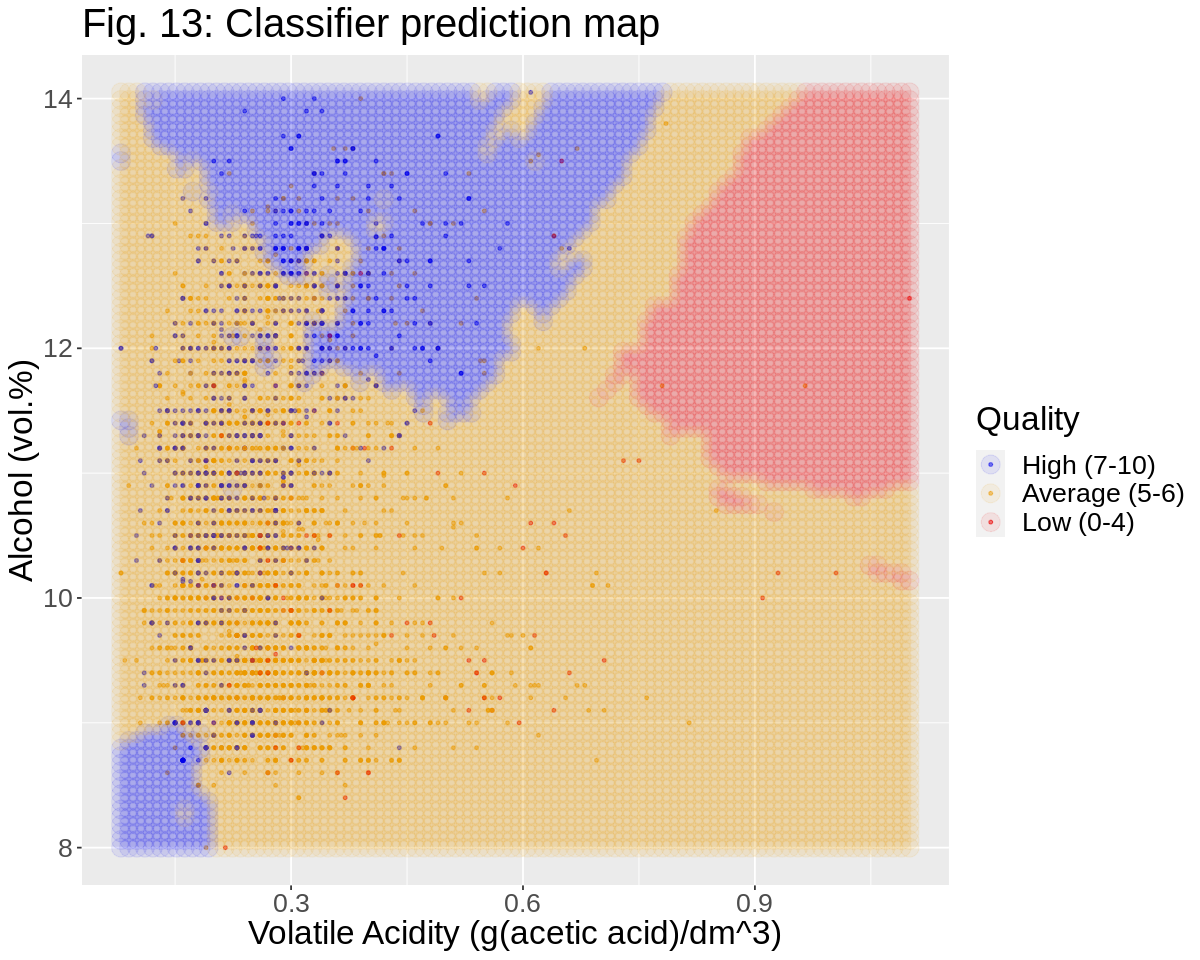

In [16]:
options(repr.plot.width = 10, repr.plot.height = 8)

# group low, average, and high quality wines together
wine_train_grouped <- wine_train |> 
    mutate(grouped_score = case_when(quality %in% c(0,1,2,3,4) ~ "Low (0-4)", 
                                     quality %in% c(5,6) ~ "Average (5-6)", 
                                     quality %in% c(7,8,9,10) ~ "High (7-10)"))

wine_train_grouped$grouped_score <- factor(wine_train_grouped$grouped_score, 
                                                 levels = c("High (7-10)", "Average (5-6)", "Low (0-4)"))

# from https://datasciencebook.ca/classification1.html#puttingittogetherworkflow

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(wine_train$volatile.acidity), 
                max(wine_train$volatile.acidity), 
                length.out = 100)
smo_grid <- seq(min(wine_train$alcohol), 
                max(wine_train$alcohol), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(volatile.acidity = are_grid, 
                                alcohol = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(wine_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
    rename(quality = .pred_class) |>
    mutate(grouped_score = case_when(quality %in% c(0,1,2,3,4) ~ "Low (0-4)", 
                                     quality %in% c(5,6) ~ "Average (5-6)", 
                                     quality %in% c(7,8,9,10) ~ "High (7-10)"))

prediction_table$grouped_score <- factor(prediction_table$grouped_score, 
                                         levels = c("High (7-10)", "Average (5-6)", "Low (0-4)"))

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = wine_train_grouped, 
             mapping = aes(x = volatile.acidity, 
                           y = alcohol, 
                           color = grouped_score), 
             alpha = 0.5,
             size = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = volatile.acidity, 
                           y = alcohol, 
                           color = grouped_score), 
             alpha = 0.08, 
             size = 5) +
  labs(color = "Quality", 
       title = "Fig. 13: Classifier prediction map",
       x = "Volatile Acidity (g(acetic acid)/dm^3)", 
       y = "Alcohol (vol.%)") +
  scale_color_manual(values = c("blue2", "orange2", "red2")) +
  theme(text = element_text(size = 20))

wkflw_plot

## Discussion:

We found that it is possible to determine white wine quality using its attributes to a certain extent. Alcohol and volatile acidity have a measurable impact on quality, as our classification model predicted the quality of white wine with an accuracy of 53% on the testing data. In Figure 13, we grouped the quality of wines as either low, average, or high, and noticed that higher quality white wines tend to have higher alcohol content and lower volatile acidity than average or low quality white wines. Another observation we made was that lower quality wines have significantly higher volatile acidity than other wines, as seen in Figure 13.

We expected to find that it is possible to predict wine quality using our chosen predictors, but the accuracy of 53% was lower than we expected, even though it is above random classification (1 of 7 possible classes = 14.3%). However, analysis of the confusion matrix yielded a valuable insight: our classifier model was typically inaccurate by one quality level in cases where the model made an incorrect prediction. For instance, for prediction and truth values for quality level 5 in Figure 12, we noticed that 190 observations were correctly classified while 176 observations were incorrectly classified. 168 of the incorrect observations were classified as quality level 6, and only 8 observations were classified more than one level away as quality level 7. A similar pattern is observed for the prediction and truth values for quality level 6. 415/548 points in this truth column were correctly classified, and the rest either ended up as 5 or 7, which are one quality level away. The model was not accurate when predicting wines at the extremes of the quality scale. For example, two wines were supposed to be classified as quality level 9, but both of them were classified as 6, as seen in Figure 12. In addition, the model also did not predict quality classes 0, 1, 2, 3, 4, 8, 9, or 10 at all. These issues are likely due to the lack of data in these classes, creating a class imbalance which ultimately affects the performance of the classification model. A possible solution to this problem could be to upsample the data so that classes with fewer observations can have more impact in the model, but we did not explore this idea in our report.

These findings suggest that there may be some way to make a higher quality white wine using the correct balance of attributes. Wine manufacturers could experiment with manufacturing processes and grape variants to affect different attributes of the wine in order to create a higher quality wine. In addition, these findings may also apply to different variants of wine such as red wine. The findings could also have an impact on other alcoholic beverages similar to wine that require fermentation or aging.

Some future questions our findings led to:
- Is there a better way to classify wine quality?
- What impact will additional predictors have on accuracy?
- Can the same predictors be used to determine wine quality of wines from other parts of the world? 
- Will the same predictors be able to predict quality for different types of wine (red wine), or even other alcoholic beverages? 

## Sources:

Jakabová, S., Fikselová, M., Mendelová, A., Ševčík, M., Jakab, I., Aláčová, Z., Kolačkovská, J., & Ivanova-Petropulos, V. (2021). Chemical composition of white wines produced from different grape varieties and wine regions in slovakia. Applied Sciences, 11(22), 11059. https://doi.org/10.3390/app112211059

Liguori, L., Albanese, D., Crescitelli, A., Di Matteo, M., & Russo, P. (2019). Impact of dealcoholization on quality properties in white wine at various alcohol content levels. Journal of food science and technology, 56(8), 3707–3720. https://doi.org/10.1007/s13197-019-03839-x

Sharma, A. K., Singh, P. N., & Sawant, S. D. (2012). Evaluation of Fermentation Efficiency of Yeast Strains and their Effect on Quality of Young Wines. Indian journal of microbiology, 52(3), 495–499. https://doi.org/10.1007/s12088-011-0226-y 